<a href="https://colab.research.google.com/github/taiconley/k-modes-clustering/blob/master/ML_K_Modes_Clustering_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Template] K-Modes Machine Learning Clustering

#### Notes:
* This code analyzes DCM Data Transfer files to impression level content pathing before a conversion. We then run K-Modes (https://pypi.org/project/kmodes/), which clusters categorical data.
* To use:
  * Update the project_id to one you have access to
  * Update query parameters for the client and campaigns you are analyzing
  * pip install kmodes


# Import libraries, Initialize BQ, and provide Parameters

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# colab tools & bigquery library
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
bigquery.USE_LEGACY_SQL = False
project_id = "" #@param {type:"string"}
query_project_id = "" #@param {type:"string"}
client = bigquery.Client(project=project_id)

!pip install --upgrade -q gspread
import gspread
from oauth2client.client import GoogleCredentials


In [0]:
#Query Parameters
dataset_name = "" #@param
client_id = "" #@param
impression_table = "`"+dataset_name+".impression_"+client_id+"`" #@param
activity_table = "`"+dataset_name+".activity_"+client_id+"`" #@param


campaign_IDs =  "('')" #@param
dbm_InsertionOrder_IDs = "('')" #@param
activity_IDs = "('')" #@param

timezone = "'America/New_York'" #@param
start_date = "'2018-01-01'" #@param
end_date  = "'2018-12-31'" #@param
time_lag_days = "30" #@param

#sample rate is the inverse of selection. ie, if 5 is picked, sample rate is 1 in 5
sample_rate = 10 #@param 

# Check Redaction

In [0]:
query_redaction = '''
SELECT
Count (*) as Impressions,
SUM (Case when User_ID = '0' THEN 1 ELSE 0 END) AS User_ID0,
SUM (Active_View_Eligible_Impressions) AS Eligible_Impressions,
SUM (Active_View_Measurable_Impressions) AS Measurable_Impressions,
SUM (Active_View_Viewable_Impressions) AS Viewable_Impressions
FROM {impression_table}
#WHERE Campaign_ID IN {campaign_IDs}
WHERE DBM_Insertion_Order_ID IN {dbm_InsertionOrder_IDs}
AND CAST(DATE(TIMESTAMP_MICROS(CAST(Event_Time as INT64)),"America/New_York") AS STRING) BETWEEN {start_date} AND {end_date}
'''.format(impression_table=impression_table,campaign_IDs=campaign_IDs, dbm_InsertionOrder_IDs=dbm_InsertionOrder_IDs, start_date=start_date, end_date=end_date)

In [0]:
df_redaction = pd.io.gbq.read_gbq(query_redaction, project_id=project_id, dialect='standard', verbose=False)

/usr/local/lib/python2.7/dist-packages/pandas_gbq/gbq.py:810: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


In [0]:
df_redaction['Redaction']=df_redaction['User_ID0']/df_redaction['Impressions']
df_redaction

,Impressions,User_ID0,Eligible_Impressions,Measurable_Impressions,Viewable_Impressions,Redaction
0,1056413690,26416142,584405423,549213204,340170124,0.025005


# Explore URL Categories

In [0]:
query_urlscat = '''
SELECT
  DBM_URL,
  DBM_adx_Page_Categories,
  Count (*) as Impressions
FROM {impression_table}
  WHERE Campaign_ID IN {campaign_IDs}
  #AND DBM_adx_Page_Categories	LIKE '%7 %' #to get a specific category example
  AND DBM_Insertion_Order_ID IN {dbm_InsertionOrder_IDs}
  AND User_ID != '0'
  AND CAST(DATE(TIMESTAMP_MICROS(CAST(Event_Time as INT64)),"America/New_York") AS STRING) BETWEEN {start_date} AND {end_date}
GROUP BY 1,2
LIMIT 1000
'''.format(impression_table=impression_table,campaign_IDs=campaign_IDs,dbm_InsertionOrder_IDs=dbm_InsertionOrder_IDs,start_date=start_date,end_date=end_date)

In [0]:
df_urlscat = pd.io.gbq.read_gbq(query_urlscat, project_id=project_id, dialect='standard', verbosity=False)

In [0]:
pd.set_option('display.max_colwidth', -1) #needed to see full url path
df_urlscat.head()

,DBM_URL,DBM_adx_Page_Categories,Impressions
0,http://www.foxnews.com/person/c/rachel-campos-duffy.html,3 16 36 112 358 1049,5
1,https://www.washingtonpost.com/news/dr-gridlock/wp/2018/03/08/with-urging-from-montgomery-co-officials-metro-preps-to-ramp-up-shady-grove-service-in-early-2019/,12 50 67 268 533 667 685 708 1084 5000 5237 5257 5277 5427,2
2,https://www.investopedia.com/ask/answers/accrued-interest-why-do-i-pay-when-i-buy-bond/,7 107 1457 1458,141
3,http://mentalfloss.com/article/18143/10-celebrity-tombstones-worth-laugh,3 22 34 182 184 895,2
4,http://www.ebay.com/sch/i.html?_nkw=wick+rope&ul_noapp=true,3 12 20 24 65 263 284 566 1230 1361,2


# Main Queries to prep model and for data exploration

## User level output, which gets sent to K-Modes Model

In [0]:
query_dfMain = '''

WITH 
conversions AS (  #Note - this includes unattributed conversions
  SELECT
    User_ID,
    MAX (Event_Time) AS Activity_Time # Capture the last site event for the user 
  FROM {activity_table}
  WHERE User_ID != "0"
    AND Activity_ID IN {activity_IDs}
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
    #AND User_ID = ''
  GROUP BY 1
),
 
impressions AS (
  SELECT
    User_ID,
    Event_Time AS Interaction_Time,
    DBM_URL,
    DBM_Adx_Page_Categories
    #DATETIME(TIMESTAMP_MICROS(Event_Time),{timezone}) AS Interaction_Time_Formatted
  FROM {impression_table}
  WHERE User_ID != "0"
    AND DBM_URL IS NOT NULL
    AND DBM_Adx_Page_Categories IS NOT NULL
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
),

full_path AS (
  SELECT *,
    (Activity_Time - Interaction_Time) as time_lag,
    (Activity_Time - Interaction_Time) * (1e6*60*60*24) as time_lag_days
  FROM impressions
  INNER JOIN conversions USING (User_ID)
    WHERE (Activity_Time - Interaction_Time) > 0
    AND (Activity_Time - Interaction_Time) < {time_lag_days}*(1e6*60*60*24)
),

all_categories AS (
SELECT 
  User_ID,
  CONCAT(",",REPLACE(REPLACE(STRING_AGG (DISTINCT DBM_ADX_Page_Categories), ","," ")," ",",")) as category
FROM full_path
GROUP BY 1
)

SELECT
  User_ID,
  category,
  CASE WHEN category LIKE '%,3,%' THEN 1 ELSE 0 END AS Acting_Theater,
  CASE WHEN category LIKE '%,47,%' THEN 1 ELSE 0 END AS Autos_Vehicles,
  CASE WHEN category LIKE '%,44,%' THEN 1 ELSE 0 END AS Beauty_Fitness,
  CASE WHEN category LIKE '%,22,%' THEN 1 ELSE 0 END AS Books_Literature,
  CASE WHEN category LIKE '%,12,%' THEN 1 ELSE 0 END AS Business_Industrial,
  CASE WHEN category LIKE '%,5,%' THEN 1 ELSE 0 END AS Computers_Electronics,
  CASE WHEN category LIKE '%,7,%' THEN 1 ELSE 0 END AS Finance,
  CASE WHEN category LIKE '%,8,%' THEN 1 ELSE 0 END AS Games,
  CASE WHEN category LIKE '%,45,%' THEN 1 ELSE 0 END AS Health,
  CASE WHEN category LIKE '%,65,%' THEN 1 ELSE 0 END AS Hobbies_Leisure,
  CASE WHEN category LIKE '%,11,%' THEN 1 ELSE 0 END AS Home_Garden,
  CASE WHEN category LIKE '%,13,%' THEN 1 ELSE 0 END AS Internet_Telecom,
  CASE WHEN category LIKE '%,958,%' THEN 1 ELSE 0 END AS Jobs_Education,
  CASE WHEN category LIKE '%,19,%' THEN 1 ELSE 0 END AS Law_Government,
  CASE WHEN category LIKE '%,16,%' THEN 1 ELSE 0 END AS News,
  CASE WHEN category LIKE '%,299,%' THEN 1 ELSE 0 END AS Online_Communities,
  CASE WHEN category LIKE '%,14,%' THEN 1 ELSE 0 END AS People_Society,
  CASE WHEN category LIKE '%,66,%' THEN 1 ELSE 0 END AS Pets_Animals,
  CASE WHEN category LIKE '%,29,%' THEN 1 ELSE 0 END AS Real_Estate,
  CASE WHEN category LIKE '%,533,%' THEN 1 ELSE 0 END AS Reference,
  CASE WHEN category LIKE '%,174,%' THEN 1 ELSE 0 END AS Science,
  CASE WHEN category LIKE '%,18,%' THEN 1 ELSE 0 END AS Shopping,
  CASE WHEN category LIKE '%,20,%' THEN 1 ELSE 0 END AS Sports,
  CASE WHEN category LIKE '%,67,%' THEN 1 ELSE 0 END AS Travel,
  CASE WHEN category LIKE '%,5000,%' THEN 1 ELSE 0 END AS World_Localities
FROM
  all_categories
  #WHERE MOD(ABS(Farm_Fingerprint (User_ID)),{sample_rate})=0 #uncomment if you need to sample your data
'''.format(activity_table=activity_table,activity_IDs=activity_IDs,timezone=timezone,start_date=start_date,end_date=end_date,impression_table=impression_table,time_lag_days=time_lag_days,sample_rate=sample_rate)

In [0]:
df_main = pd.io.gbq.read_gbq(query_dfMain, project_id=project_id, dialect='standard', verbose=False)

In [0]:
df_main.head()

,User_ID,category,Acting_Theater,Autos_Vehicles,Beauty_Fitness,Books_Literature,Business_Industrial,Computers_Electronics,Finance,Games,...,Online_Communities,People_Society,Pets_Animals,Real_Estate,Reference,Science,Shopping,Sports,Travel,World_Localities
0,AMsySZYyEcvFyiFzpcJeM61T0Mmj,",3,16,20,258,569,1001,1077,1273,1599,7,16,107,...",1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,1,1
1,AMsySZal23z96xWjZStlYidOAtmj,",16,20,259,1001,1077,5000,5237,5257,5259,5261,...",1,0,0,0,1,1,1,1,...,0,0,0,0,1,0,1,1,0,1
2,AMsySZaNwJ3uf1tRjAtyBkdBXfIA,",7,16,18,107,531,784,1163,1179,22,533,692,980",0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
3,AMsySZaz_ZJRKd-_Ff8cF6xjpch-,",71,122,909,911,913,1512,1544,1566",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMsySZYy22pUmBwYvQsI4oDsD0rK,",5,434,533,694,742,980,18,292,531,18,64,292,53...",0,0,0,0,1,1,0,0,...,1,0,0,0,1,0,1,0,1,1


## Paths output for all converters only (Used to calculate lift)

In [0]:
query_dfAllPathsConverters = '''

# query provides an output with the count of cookies aggregated to the path level for converters only
WITH 
conversions AS (  #Note - this includes unattributed conversions
  SELECT
    User_ID,
    MAX (Event_Time) AS Activity_Time # Capture the last site event for the user 
  FROM {activity_table}
  WHERE User_ID != "0"
    AND Activity_ID IN {activity_IDs}
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
    #AND User_ID = ''
  GROUP BY 1
),
 
impressions AS (
  SELECT
    User_ID,
    Event_Time AS Interaction_Time,
    DBM_URL,
    DBM_Adx_Page_Categories
    #DATETIME(TIMESTAMP_MICROS(Event_Time),{timezone}) AS Interaction_Time_Formatted
  FROM {impression_table}
  WHERE User_ID != "0"
    AND DBM_URL IS NOT NULL
    AND DBM_Adx_Page_Categories IS NOT NULL
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
),

full_path AS (
  SELECT *,
    (Activity_Time - Interaction_Time) as time_lag,
    (Activity_Time - Interaction_Time) * (1e6*60*60*24) as time_lag_days
  FROM impressions
  INNER JOIN conversions USING (User_ID)
    WHERE (Activity_Time - Interaction_Time) > 0
    AND (Activity_Time - Interaction_Time) < {time_lag_days}*(1e6*60*60*24)
),

all_categories AS (
SELECT 
  User_ID,
  CONCAT(",",REPLACE(REPLACE(STRING_AGG (DISTINCT DBM_ADX_Page_Categories), ","," ")," ",",")) as category
FROM full_path
  GROUP BY 1
),

all_categories_sampled AS (

SELECT
  User_ID,
  category,
  CASE WHEN category LIKE '%,3,%' THEN 1 ELSE 0 END AS Acting_Theater,
  CASE WHEN category LIKE '%,47,%' THEN 1 ELSE 0 END AS Autos_Vehicles,
  CASE WHEN category LIKE '%,44,%' THEN 1 ELSE 0 END AS Beauty_Fitness,
  CASE WHEN category LIKE '%,22,%' THEN 1 ELSE 0 END AS Books_Literature,
  CASE WHEN category LIKE '%,12,%' THEN 1 ELSE 0 END AS Business_Industrial,
  CASE WHEN category LIKE '%,5,%' THEN 1 ELSE 0 END AS Computers_Electronics,
  CASE WHEN category LIKE '%,7,%' THEN 1 ELSE 0 END AS Finance,
  CASE WHEN category LIKE '%,8,%' THEN 1 ELSE 0 END AS Games,
  CASE WHEN category LIKE '%,45,%' THEN 1 ELSE 0 END AS Health,
  CASE WHEN category LIKE '%,65,%' THEN 1 ELSE 0 END AS Hobbies_Leisure,
  CASE WHEN category LIKE '%,11,%' THEN 1 ELSE 0 END AS Home_Garden,
  CASE WHEN category LIKE '%,13,%' THEN 1 ELSE 0 END AS Internet_Telecom,
  CASE WHEN category LIKE '%,958,%' THEN 1 ELSE 0 END AS Jobs_Education,
  CASE WHEN category LIKE '%,19,%' THEN 1 ELSE 0 END AS Law_Government,
  CASE WHEN category LIKE '%,16,%' THEN 1 ELSE 0 END AS News,
  CASE WHEN category LIKE '%,299,%' THEN 1 ELSE 0 END AS Online_Communities,
  CASE WHEN category LIKE '%,14,%' THEN 1 ELSE 0 END AS People_Society,
  CASE WHEN category LIKE '%,66,%' THEN 1 ELSE 0 END AS Pets_Animals,
  CASE WHEN category LIKE '%,29,%' THEN 1 ELSE 0 END AS Real_Estate,
  CASE WHEN category LIKE '%,533,%' THEN 1 ELSE 0 END AS Reference,
  CASE WHEN category LIKE '%,174,%' THEN 1 ELSE 0 END AS Science,
  CASE WHEN category LIKE '%,18,%' THEN 1 ELSE 0 END AS Shopping,
  CASE WHEN category LIKE '%,20,%' THEN 1 ELSE 0 END AS Sports,
  CASE WHEN category LIKE '%,67,%' THEN 1 ELSE 0 END AS Travel,
  CASE WHEN category LIKE '%,5000,%' THEN 1 ELSE 0 END AS World_Localities
FROM
  all_categories
  #WHERE MOD(ABS(Farm_Fingerprint (User_ID)),{sample_rate})=0 #uncomment to sample data
),

categories_string AS (
SELECT
  User_ID,
  category,
  concat(
  CAST (Acting_Theater AS string), "," ,
  CAST (Autos_Vehicles AS string), "," ,
  CAST (Beauty_Fitness AS string), "," ,
  CAST (Books_Literature AS string), "," ,
  CAST (Business_Industrial AS string), "," ,
  CAST (Computers_Electronics AS string), "," ,
  CAST (Finance AS string), "," ,
  CAST (Games AS string), "," ,
  CAST (Health AS string), "," ,
  CAST (Hobbies_Leisure AS string), "," ,
  CAST (Home_Garden AS string), "," ,
  CAST (Internet_Telecom AS string), "," ,
  CAST (Jobs_Education AS string), "," ,
  CAST (Law_Government AS string), "," ,
  CAST (News AS string), "," ,
  CAST (Online_Communities AS string), "," ,
  CAST (People_Society AS string), "," ,
  CAST (Pets_Animals AS string), "," ,
  CAST (Real_Estate AS string), "," ,
  CAST (Reference AS string), "," ,
  CAST (Science AS string), "," ,
  CAST (Shopping AS string), "," ,
  CAST (Sports AS string), "," ,
  CAST (Travel AS string), "," ,
  CAST (World_Localities AS string)) AS category_string
FROM all_categories_sampled
)

SELECT
  category_string,
  COUNT (User_ID) AS uniques
FROM
  categories_string
  GROUP BY 1
  ORDER BY 2 DESC
'''.format(activity_table=activity_table,activity_IDs=activity_IDs,timezone=timezone,start_date=start_date,end_date=end_date,impression_table=impression_table,time_lag_days=time_lag_days,sample_rate=sample_rate)

In [0]:
df_allPaths_Converters = pd.io.gbq.read_gbq(query_dfAllPathsConverters, project_id=project_id, dialect='standard', verbose=False)

In [0]:
df_allPaths_Converters.head()

,category_string,uniques
0,"0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0",16836
1,"0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0",7336
2,"0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",7213
3,"0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0",4608
4,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0",3909


## Paths output for all users (Used to calculate lift)

In [0]:
query_allPaths = '''

# query provides an output with the count of cookies aggregated to the path level
WITH 
 
impressions AS (
  SELECT
    User_ID,
    Event_Time AS Interaction_Time,
    DBM_URL,
    DBM_Adx_Page_Categories
  FROM {impression_table}
  WHERE User_ID != "0"
    AND DBM_URL IS NOT NULL
    AND DBM_Adx_Page_Categories IS NOT NULL
    AND DATE(TIMESTAMP_MICROS(Event_Time),{timezone}) BETWEEN {start_date} AND {end_date}
),

all_categories AS (
SELECT 
  User_ID,
  CONCAT(",",REPLACE(REPLACE(STRING_AGG (DISTINCT DBM_ADX_Page_Categories), ","," ")," ",",")) as category
FROM impressions
  GROUP BY 1
),

all_categories_sampled AS (
SELECT
  User_ID,
  category,
  CASE WHEN category LIKE '%,3,%' THEN 1 ELSE 0 END AS Acting_Theater,
  CASE WHEN category LIKE '%,47,%' THEN 1 ELSE 0 END AS Autos_Vehicles,
  CASE WHEN category LIKE '%,44,%' THEN 1 ELSE 0 END AS Beauty_Fitness,
  CASE WHEN category LIKE '%,22,%' THEN 1 ELSE 0 END AS Books_Literature,
  CASE WHEN category LIKE '%,12,%' THEN 1 ELSE 0 END AS Business_Industrial,
  CASE WHEN category LIKE '%,5,%' THEN 1 ELSE 0 END AS Computers_Electronics,
  CASE WHEN category LIKE '%,7,%' THEN 1 ELSE 0 END AS Finance,
  CASE WHEN category LIKE '%,8,%' THEN 1 ELSE 0 END AS Games,
  CASE WHEN category LIKE '%,45,%' THEN 1 ELSE 0 END AS Health,
  CASE WHEN category LIKE '%,65,%' THEN 1 ELSE 0 END AS Hobbies_Leisure,
  CASE WHEN category LIKE '%,11,%' THEN 1 ELSE 0 END AS Home_Garden,
  CASE WHEN category LIKE '%,13,%' THEN 1 ELSE 0 END AS Internet_Telecom,
  CASE WHEN category LIKE '%,958,%' THEN 1 ELSE 0 END AS Jobs_Education,
  CASE WHEN category LIKE '%,19,%' THEN 1 ELSE 0 END AS Law_Government,
  CASE WHEN category LIKE '%,16,%' THEN 1 ELSE 0 END AS News,
  CASE WHEN category LIKE '%,299,%' THEN 1 ELSE 0 END AS Online_Communities,
  CASE WHEN category LIKE '%,14,%' THEN 1 ELSE 0 END AS People_Society,
  CASE WHEN category LIKE '%,66,%' THEN 1 ELSE 0 END AS Pets_Animals,
  CASE WHEN category LIKE '%,29,%' THEN 1 ELSE 0 END AS Real_Estate,
  CASE WHEN category LIKE '%,533,%' THEN 1 ELSE 0 END AS Reference,
  CASE WHEN category LIKE '%,174,%' THEN 1 ELSE 0 END AS Science,
  CASE WHEN category LIKE '%,18,%' THEN 1 ELSE 0 END AS Shopping,
  CASE WHEN category LIKE '%,20,%' THEN 1 ELSE 0 END AS Sports,
  CASE WHEN category LIKE '%,67,%' THEN 1 ELSE 0 END AS Travel,
  CASE WHEN category LIKE '%,5000,%' THEN 1 ELSE 0 END AS World_Localities
FROM
  all_categories
  #WHERE MOD(ABS(Farm_Fingerprint (User_ID)),{sample_rate})=0 #uncomment to sample data
),

categories_string AS (
SELECT
  User_ID,
  category,
  concat(
  CAST (Acting_Theater AS string), "," ,
  CAST (Autos_Vehicles AS string), "," ,
  CAST (Beauty_Fitness AS string), "," ,
  CAST (Books_Literature AS string), "," ,
  CAST (Business_Industrial AS string), "," ,
  CAST (Computers_Electronics AS string), "," ,
  CAST (Finance AS string), "," ,
  CAST (Games AS string), "," ,
  CAST (Health AS string), "," ,
  CAST (Hobbies_Leisure AS string), "," ,
  CAST (Home_Garden AS string), "," ,
  CAST (Internet_Telecom AS string), "," ,
  CAST (Jobs_Education AS string), "," ,
  CAST (Law_Government AS string), "," ,
  CAST (News AS string), "," ,
  CAST (Online_Communities AS string), "," ,
  CAST (People_Society AS string), "," ,
  CAST (Pets_Animals AS string), "," ,
  CAST (Real_Estate AS string), "," ,
  CAST (Reference AS string), "," ,
  CAST (Science AS string), "," ,
  CAST (Shopping AS string), "," ,
  CAST (Sports AS string), "," ,
  CAST (Travel AS string), "," ,
  CAST (World_Localities AS string)) AS category_string
FROM all_categories_sampled
)

SELECT
  category_string,
  COUNT (User_ID) AS uniques
  FROM
  categories_string
  GROUP BY 1
  ORDER BY 2 DESC
'''.format(impression_table=impression_table,timezone=timezone,start_date=start_date,end_date=end_date,sample_rate=sample_rate)

In [0]:
df_allPaths = pd.io.gbq.read_gbq(query_allPaths, project_id=project_id, dialect='standard', verbose=False)

In [0]:
df_allPaths.head()

,category_string,uniques
0,"0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0",12472050
1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",3481595
2,"0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0",3380256
3,"0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",3203000
4,"0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0",2813430


In [0]:
df_main.drop(['category'], axis=1).head()

,User_ID,Acting_Theater,Autos_Vehicles,Beauty_Fitness,Books_Literature,Business_Industrial,Computers_Electronics,Finance,Games,Health,...,Online_Communities,People_Society,Pets_Animals,Real_Estate,Reference,Science,Shopping,Sports,Travel,World_Localities
0,AMsySZYyEcvFyiFzpcJeM61T0Mmj,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,1,1
1,AMsySZal23z96xWjZStlYidOAtmj,1,0,0,0,1,1,1,1,0,...,0,0,0,0,1,0,1,1,0,1
2,AMsySZaNwJ3uf1tRjAtyBkdBXfIA,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
3,AMsySZaz_ZJRKd-_Ff8cF6xjpch-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMsySZYy22pUmBwYvQsI4oDsD0rK,0,0,0,0,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1,1


In [0]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240738 entries, 0 to 240737
Data columns (total 27 columns):
User_ID                  240738 non-null object
category                 240738 non-null object
Acting_Theater           240738 non-null int64
Autos_Vehicles           240738 non-null int64
Beauty_Fitness           240738 non-null int64
Books_Literature         240738 non-null int64
Business_Industrial      240738 non-null int64
Computers_Electronics    240738 non-null int64
Finance                  240738 non-null int64
Games                    240738 non-null int64
Health                   240738 non-null int64
Hobbies_Leisure          240738 non-null int64
Home_Garden              240738 non-null int64
Internet_Telecom         240738 non-null int64
Jobs_Education           240738 non-null int64
Law_Government           240738 non-null int64
News                     240738 non-null int64
Online_Communities       240738 non-null int64
People_Society           240738 non-null 

#Modeling

In [0]:
!pip install kmodes

    100% |████████████████████████████████| 5.0MB 4.1MB/s 
imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [0]:
# Another way to sample data
df_mainSampled=df_main.sample(n=10000, random_state=1)

[36869.0, 32327.0, 28201.0, 26762.0, 26143.0, 24975.0, 23724.0, 24140.0, 23075.0, 22868.0, 22061.0, 22253.0, 21309.0, 21223.0, 21255.0, 20950.0, 20661.0, 19819.0, 20346.0, 19793.0]


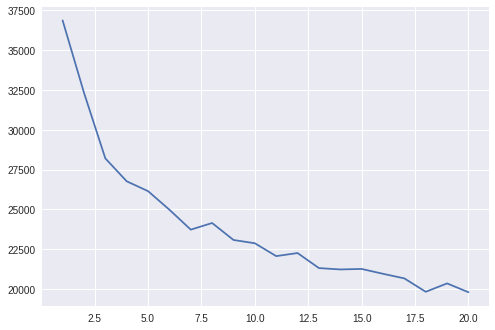

In [0]:
# Run the elbow method.  Run the model n times, and find the loss for each n.  We then apply n where loss starts to level out. This will be slow, especially with unsampled data. 
from kmodes.kmodes import KModes


data = df_mainSampled.drop(['User_ID', 'category'], axis=1) #use if you want sampled data
#data = df_main.drop(['User_ID', 'category'], axis=1) #use if you want full data

lst = []
n = 20 #user change for elbow method testing

def process(n):
    km = KModes(n_clusters=n, init='Huang', n_init=10, verbose=0)
    clusters = km.fit_predict(data)
    lst.append(km.cost_)

for i in range(n):
    process(i+1)

print(lst)
plt.plot(range(1,n+1),lst)
plt.show()

In [0]:
#make clusters 
import numpy as np
from kmodes.kmodes import KModes

total_clusters = 6 #user to change based on results from elbow method
lst = []

data = df_main.drop(['User_ID', 'category'], axis=1)

km = KModes(n_clusters=total_clusters, init='Huang', n_init=10, verbose=0)
#also tested with 'Cao' init method, and with n_init of 5 and 10. 

clusters = km.fit_predict(data)

# Print the cluster centroids
lst.append(km.cluster_centroids_)
print(lst[0])

[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0]]


In [0]:
columns=list(df_main.drop(columns=['User_ID','category'])) # get column names
df_modelOut = pd.DataFrame(lst[0])
df_modelOut.columns=columns
df_modelOut

,Acting_Theater,Autos_Vehicles,Beauty_Fitness,Books_Literature,Business_Industrial,Computers_Electronics,Finance,Games,Health,Hobbies_Leisure,...,Online_Communities,People_Society,Pets_Animals,Real_Estate,Reference,Science,Shopping,Sports,Travel,World_Localities
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,1,1,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [0]:
df_allPathsMerged = df_allPaths_Converters.merge(df_allPaths,how='inner',on='category_string') #inner join converter and all_paths dataframes together
df_allPathsMerged = df_allPathsMerged.rename(index=str, columns={"category_string": "Category", "uniques_x": "Unique_Converters", "uniques_y": "Unique_All"}) #rename columns
df_allPathsMerged["Conversion_Rate"] = df_allPathsMerged["Unique_Converters"]/df_allPathsMerged["Unique_All"] #build conversion rate column

In [0]:
#if you want to open an existing spreadsheet
gc = gspread.authorize(GoogleCredentials.get_application_default())
#sh = gc.open('K-Mode Output')
#sh = gc.open_by_key('key here')
sh = gc.open_by_url('url here')

In [0]:
# add new sheets to worksheet
worksheet_kmodes = sh.add_worksheet(title="KModes", rows="100", cols="30")
worksheet_allPathsMerged = sh.add_worksheet(title="All Paths Merged", rows="50000", cols="20")

In [0]:
# get sheets if they already exist
worksheet_kmodes = sh.worksheet("KModes")
worksheet_allPathsMerged = sh.worksheet("All Paths Merged")

In [0]:
# functions needed to send to sheets
def num_to_col_letters(num):
    letters = ''
    while num:
        mod = (num - 1) % 26
        letters += chr(mod + 65)
        num = (num - 1) // 26
    return ''.join(reversed(letters))

def df_to_sheet(df, worksheet):
  ran = 'A1:'+num_to_col_letters(df.shape[1])+str(df.shape[0]+1)
  cell_list = worksheet.range(ran)
  df_list = df.values.tolist()
  flat_list = [item for sublist in df_list for item in sublist]
  list_headers = list(df.columns.values)
  flat_list=list_headers+flat_list

  for cell, value in zip(cell_list, flat_list):
    cell.value = value

  worksheet.update_cells(cell_list)

#function to return dataframe from sheets
def df_from_sheet(worksheet):
  list_of_lists = worksheet.get_all_values()
  return pd.DataFrame(list_of_lists[1:], columns=list_of_lists[0])

In [0]:
#send final results to sheets
df_to_sheet(df_modelOut, worksheet_kmodes)
df_to_sheet(df_allPathsMerged, worksheet_allPathsMerged)

# Data Exploration

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'All Categories')

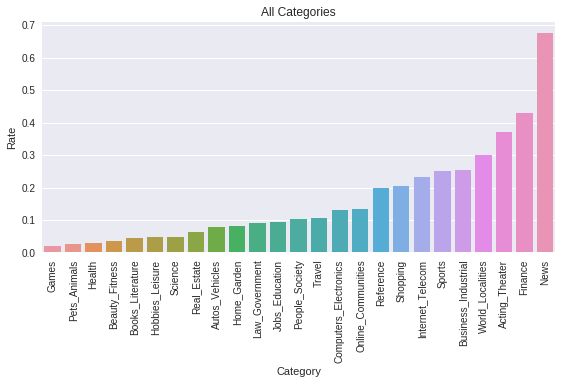

In [0]:
#shows rate that each category shows up in a converting path
col_list= list(df_main)
col_list.remove('User_ID')
col_list.remove('category')

summary = df_main[col_list].sum().sort_values(ascending = False)
summary2 = df_main[col_list].count().sort_values(ascending = False)

dfexp = pd.concat([summary, summary2], axis=1)
dfexp = dfexp.reset_index()
dfexp = dfexp.rename(index=str, columns={"index": "Category", 0: "Sum", 1: "Count"})
dfexp = dfexp.sort_values('Sum')
dfexp['Rate']=dfexp['Sum']/dfexp['Count']

g = sns.factorplot(x="Category",y='Rate', kind='bar',aspect=2, data=dfexp)
g.set_xticklabels(rotation=90)
g.ax.set_title("All Categories")

In [0]:
n = 4 #user input
lst_summary = list(summary.index)[0:n]

In [0]:
#custom function
def process (sub_category):
  mask = df_main[sub_category] == 1
  df_category = df_main[mask]
  mask = 0
  summary_category = df_category[col_list].sum().sort_values()
  summary2_category = df_category[col_list].count().sort_values()
  df2_category = pd.concat([summary_category, summary2_category], axis=1)
  df2_category = df2_category.reset_index()
  df2_category = df2_category.rename(index=str, columns={"index": "Category", 0: "Sum", 1: "Count"})
  df2_category = df2_category.sort_values('Sum')
  df2_category['Rate']=df2_category['Sum']/df2_category['Count']
  mask2=df2_category['Category'] != sub_category
  df2_category = df2_category[mask2]
  mask2 = 0
  g_category = sns.factorplot(x="Category",y='Rate', kind='bar',aspect=2, data=df2_category, margin_titles=True)
  g_category.set_xticklabels(rotation=90)
  g_category.ax.set_title("Category: "+str(sub_category))

News
Finance
Acting_Theater
World_Localities


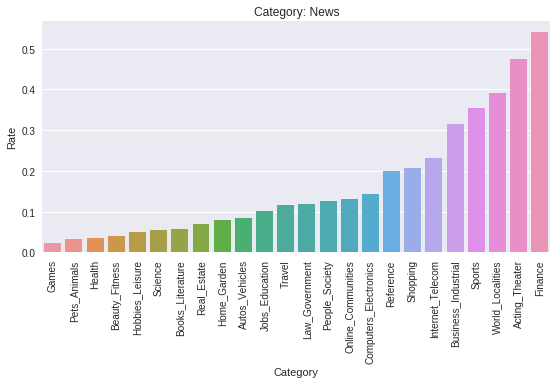

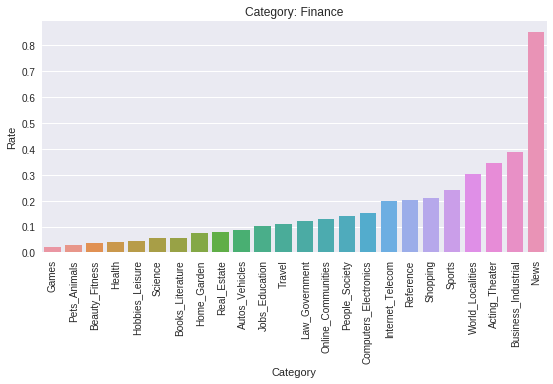

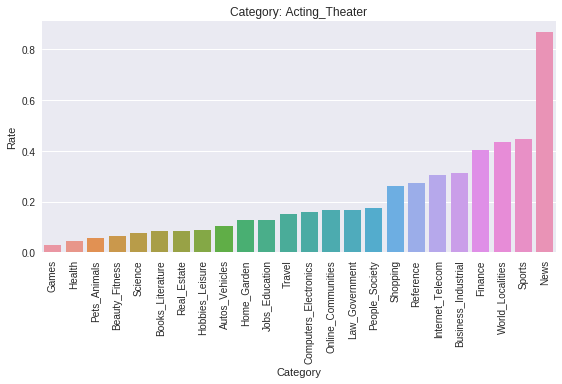

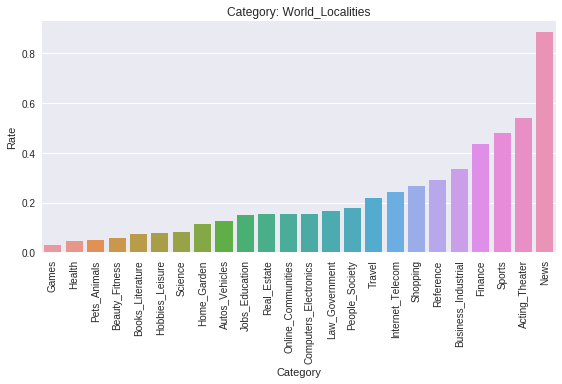

In [0]:
#the output shows overlap. For example, if a converting user sees News, what other categories do they also see?
for x in lst_summary:
  print x
  process(x)